# Tutorial 3a. Homemade one-hidden layer perceptron for binary classification

![](mlp.svg)

## This is a homework: put your names here

- `Alexander Morakhovski`
- `Julian Lechuga Lopez`

## Description

The goal of this tutorial is to build and train your first neural network *by hand* !

- To keep things as simple as possible we consider a simple *perceptron* with *one hidden layer*
- We consider a binary-classification problem which cannot be solved with a linear classifier
- We use a toy dataset which is already created for you with the `load_data()` function

The neural network will have to be **programmed and trained from scratch**, meaning that you will have to define its structure yourself, and that **you are not allowed** to use the built-in functionalities of `PyTorch` for autodifferentiation. You will have to program the forward and backward pass *yourself*, together with the gradient descent algorithm.

**Read the following instructions carefully in order to succeed**

- You are already provided with a simple python class which will constitute your neural network. 

- The constructor of this class (`__init__`) requires you to specify the following parameters (investigate the data carefully in order to know how these parameters need to be defined).
    - Number of input nodes (number of features)
    - Number of hidden units 
    - Number of output nodes

- The constructor of the neural network also requires you to allocate the weight matrices and bias vectors which will be the main components of your computational graph. For this, you can use some of the tensor operations we have seen in `tutorial2a`, in order to initialize at random the weights, for instance.

- Implementing a neural network consists in two main steps:
    - Forward-pass: computing the output of the network based on its weight matrices and bias vectors. Since we consider binary classification, we should output activations that are activated by a sigmoid
    - Backward-pass: computing how different the predictions of the network are from what should be predicted and update the parameters of the network with the backpropagation algorithm. You are already provided with a loss function in the code which requires only slight modifications.

- If you want to challenge yourself you can extend the neural network as follows:
    - add multiple hidden layers of different sizes
    - explore different non-linear activation functions
    - investigate whether the network starts overfitting

In [7]:
import numpy as np
import torch
import sklearn
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

## Simulation of the data

In [8]:
def load_data(n_samples=500):
    return make_gaussian_quantiles(
        mean=None,
        cov=0.7,
        n_samples=n_samples,
        n_features=2,
        n_classes=2,
        shuffle=True,
        random_state=42,
    )

In [9]:
gaussian_quantiles = load_data()
X, y = gaussian_quantiles

print(X[:10, :])
print(y[:10])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

[[-1.13773727  0.62436053]
 [-0.75970745 -1.18161805]
 [-0.82471758  0.42171557]
 [-0.09398039 -0.18487643]
 [-0.80731289  0.57399183]
 [ 0.67980788  1.13471182]
 [-1.70521733 -0.84342552]
 [ 1.57461467  1.12565917]
 [-0.22579357 -0.81889248]
 [ 0.97317262  0.00856159]]
[1 1 0 0 1 1 1 1 0 1]


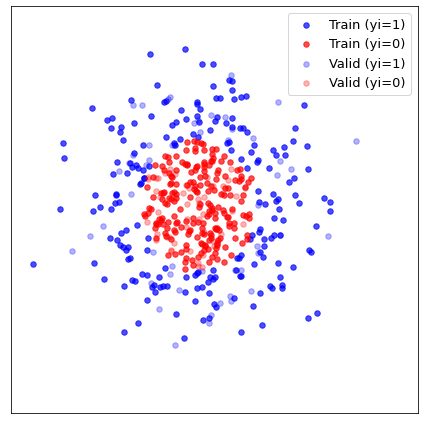

In [10]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_data(X, y, xy_labels=True, label=None, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    if label is not None:
        plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=label + " (yi=1)", **kwargs)
        plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=label + " (yi=0)", **kwargs)
    plt.xticks(())
    plt.yticks(())
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

def plot_probas(nn, X, y, h = 0.02, levels = 1):
    x_min, x_max = X[:, 0].min()- 1, X[:, 0].max() + 1.5
    y_min, y_max = X[:, 1].min() - 1.2, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    X_nn = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    yhat = nn.forward(X_nn)
    yhat = yhat.reshape(xx.shape)
    plt.contourf(xx, yy, yhat, cmap=cm, alpha=.5, levels=levels)
        
plt.figure(figsize=(6, 6))
plot_data(X_train, y_train, alpha = 0.7, label="Train")
plot_data(X_test, y_test, alpha = 0.3, label="Valid")
plt.legend(fontsize=13)
plt.tight_layout()

## A neural network class

**QUESTION.** Implement the `forward` and `backward` methods in the following class, and fill the `__init__` and `train` methods, in order to train the one-hidden layer perceptron for binary classification. 

In [11]:
class NeuralNetwork:
    
    def __init__(self, n_in, n_hidden, n_out):
        # number of input nodes
        self.n_x = n_in

        # number of hidden nodes
        self.n_h = n_hidden

        # number of output nodes
        self.n_y = n_out

        # Define 1st weight matrix (using random initialization)
        self.W1 = torch.rand(n_in, n_hidden)

        # define 1st bias vector
        self.b1 = torch.rand(n_hidden)

        # Define 2nd weight matrix (using random initialization)
        self.W2 = torch.rand(n_hidden, n_out)


        # Define 2nd bias vector
        self.b2 = torch.rand(n_out)
            
    
    def sigmoid(self,Z):
        return 1/(1 + torch.exp(-Z))

    def sigmoid_derivative(self, s):
        return s * (1 - s)
    
    def forward(self, X):
        self.Z1 = torch.matmul(X, self.W1) + self.b1
        self.A1 = self.sigmoid(self.Z1)
        self.Z2 = torch.matmul(self.A1, self.W2) + self.b2
        yhat = self.sigmoid(self.Z2)
        return yhat
        
    def backward(self, X, y, yhat):
        
        y = torch.reshape(y, (y.shape[0], 1))
        dl_wrt_z3 = yhat - y
        
        #Gradients for w2: partial derivative of cost w.r.t. w2 and b2
        
        dl_wrt_z2 = dl_wrt_z3*self.sigmoid_derivative(yhat)
        dl_wrt_w2 = torch.matmul(self.A1.T, dl_wrt_z2)
        dl_wrt_b2 = torch.sum(dl_wrt_z2, dim = 0)/y.shape[0]

        #Gradients for w1: partial derivative of cost w.r.t w1 and b1
    
        dl_wrt_z1 = torch.matmul(dl_wrt_z2, self.W2.T)* self.sigmoid_derivative(self.A1)
        dl_wrt_w1 = torch.matmul(X.T, dl_wrt_z1)
        dl_wrt_b1 = torch.sum(dl_wrt_z1, dim = 0)/y.shape[0]
        
        return dl_wrt_w1, dl_wrt_b1, dl_wrt_w2, dl_wrt_b2
        
    def train(self, X_train, y_train, epochs, learning_rate):
        loss = []
        m = X_train.shape[0]
        for e in range(epochs):
            
            
            yhat = self.forward(X_train)
            
            #self.test(X_train, y_train, yhat)
            
            training_loss = torch.mean(-(y_train*torch.log(yhat) + (1-y_train)*torch.log(1- yhat))).detach().item() 
            loss.append(training_loss)
            
            if e%100 == 0:
                print("EPOCH: {} Loss: {:0.3f} Accuracy: {:0.2f}%".format(e, training_loss, self.validate(X_train, y_train)))
            
            
            dl_wrt_w1, dl_wrt_b1, dl_wrt_w2, dl_wrt_b2 = self.backward(X_train, y_train, yhat)
            
            # update of the 1st weight matrix
            self.W1 -= learning_rate*dl_wrt_w1
            
            # update of the 1st bias vector
            self.b1 -= learning_rate*dl_wrt_b1
            
            # update of the 2nd weight matrix
            self.W2 -= learning_rate*dl_wrt_w2
            
            # update of the 2nd bias vector
            self.b2 -= learning_rate*dl_wrt_b2
        print("Final training loss: {:0.3f} Accuracy: {:0.2f}%".format(training_loss, self.validate(X_train, y_train)))
        return loss
    
    def validate(self, X_valid, y_valid):
        yhat = (self.forward(X_valid) > 0.5)
        correct = 0
        for i in range(yhat.shape[0]):
            if y_valid[i] == yhat[i]:
                correct+=1
        return correct/y_valid.shape[0]*100

**QUESTION.** Train your neural network, modify your code to save the training and validation error along the gradient descent iterations and plot them. You should also print the train and validation errors during training.

In [12]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float()
X_valid_torch = torch.from_numpy(X_test).float()
y_valid_torch = torch.from_numpy(y_test).float()

nn = NeuralNetwork(2, 16, 1)

loss = nn.train(
    X_train_torch,
    y_train_torch,
    epochs = 3000,
    learning_rate = 0.05
)

nn.validate(X_valid_torch, y_valid_torch)

EPOCH: 0 Loss: 2.494 Accuracy: 49.75%
EPOCH: 100 Loss: 0.902 Accuracy: 60.75%
EPOCH: 200 Loss: 1.754 Accuracy: 62.75%
EPOCH: 300 Loss: 1.676 Accuracy: 49.75%
EPOCH: 400 Loss: 1.111 Accuracy: 75.25%
EPOCH: 500 Loss: 1.240 Accuracy: 77.50%
EPOCH: 600 Loss: 1.338 Accuracy: 82.75%
EPOCH: 700 Loss: 1.340 Accuracy: 82.50%
EPOCH: 800 Loss: 1.491 Accuracy: 78.75%
EPOCH: 900 Loss: 1.459 Accuracy: 82.00%
EPOCH: 1000 Loss: 1.426 Accuracy: 83.00%
EPOCH: 1100 Loss: 1.506 Accuracy: 87.00%
EPOCH: 1200 Loss: 1.692 Accuracy: 78.75%
EPOCH: 1300 Loss: 1.440 Accuracy: 96.50%
EPOCH: 1400 Loss: 2.073 Accuracy: 73.25%
EPOCH: 1500 Loss: 1.747 Accuracy: 87.50%
EPOCH: 1600 Loss: 1.784 Accuracy: 89.75%
EPOCH: 1700 Loss: 1.814 Accuracy: 93.00%
EPOCH: 1800 Loss: 1.842 Accuracy: 96.50%
EPOCH: 1900 Loss: 1.922 Accuracy: 94.25%
EPOCH: 2000 Loss: 2.081 Accuracy: 88.75%
EPOCH: 2100 Loss: 2.140 Accuracy: 90.00%
EPOCH: 2200 Loss: 2.170 Accuracy: 91.00%
EPOCH: 2300 Loss: 2.193 Accuracy: 91.75%
EPOCH: 2400 Loss: 2.234 Accu

94.0

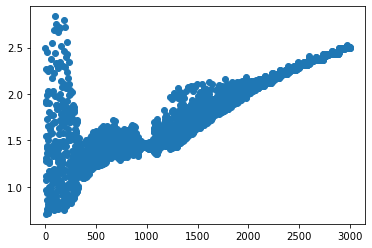

In [13]:
plt.scatter(range(len(loss)), loss, label="Train")

## Assessment of your model

**QUESTION.** Use and modify the plotting functions from this notebook and the ones from `tutorial01` in order to plot the data together with the **predicted probabilities** of your neural network for inputs in a grid covering the input features space (as we did in `tutorial01`). Also, display on the plot the AUC-ROC metric obtained by your neural net.

### Plot of predicted probabilities

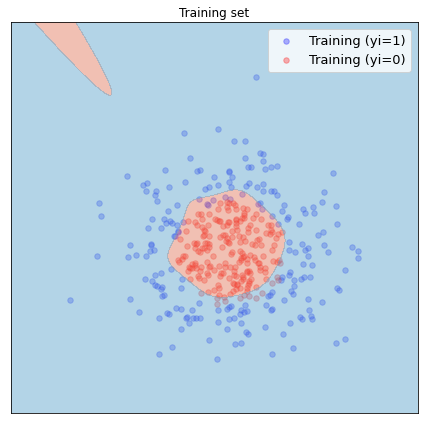

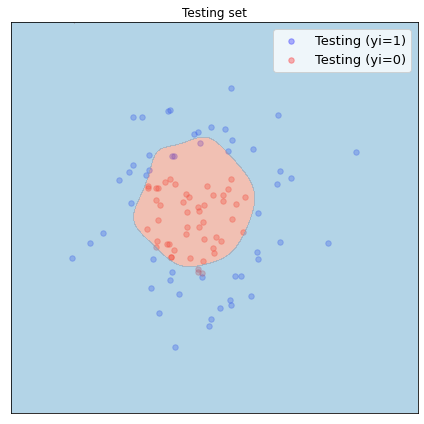

In [14]:
plt.figure(figsize=(6, 6))
plot_data(X_train, y_train, alpha = 0.3, label="Training")
plot_probas(nn, X_train, y_train)
plt.title("Training set")
plt.legend(fontsize=13)
plt.tight_layout()

plt.figure(figsize=(6, 6))
plot_data(X_test, y_test, alpha = 0.3, label="Testing")
plot_probas(nn, X_test, y_test)
plt.title("Testing set")
plt.legend(fontsize=13)
plt.tight_layout()

## Metrics

In [16]:
from sklearn.metrics import (classification_report, roc_curve, 
                             precision_recall_curve, roc_auc_score, 
                             average_precision_score)


msg = "Classification report for Neural Network"
print(msg)
print("-" * len(msg))
y = y_valid_torch == 1
y_hat = nn.forward(X_valid_torch) > 0.5
report_simple = classification_report(y, y_hat)
print(report_simple)

Classification report for Neural Network
----------------------------------------
              precision    recall  f1-score   support

       False       0.94      0.94      0.94        49
        True       0.94      0.94      0.94        51

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



In [17]:
y_score = nn.forward(X_valid_torch)

In [18]:
def plot_roc_curve(y_test, y_score, title=None, label=None, legend=True, 
                   show_thresholds=True, colorbar=True):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    thresholds[0] = 1
    roc_auc = roc_auc_score(y_test, y_score)

    if label is None:
        label='ROC curve (area = %0.2f)' % roc_auc

    if title is None:
        title = "ROC curve"

    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    
    if show_thresholds:
        norm = plt.Normalize(vmin=0, vmax=1)
        plt.plot(fpr, tpr, lw=1, label=label, alpha=0.7)
        plt.scatter(fpr, tpr, cmap=cm, c=thresholds, s=70, norm=norm)
        if colorbar:
            plt.colorbar()
    else:
        plt.plot(fpr, tpr, lw=3, label=label)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(title, fontsize=16)
    if legend:
        plt.legend(fontsize=12)

def plot_roc_curves(y_test, y_scores, labels, title=None, show_thresholds=True):
    for y_score, label in zip(y_scores, labels):
        plot_roc_curve(y_test, y_score, label=label, legend=False, 
                       show_thresholds=show_thresholds, colorbar=False)
    plt.legend(fontsize=12)
    if show_thresholds:
        plt.colorbar()
    if title is not None:
        plt.title(title, fontsize=16)     

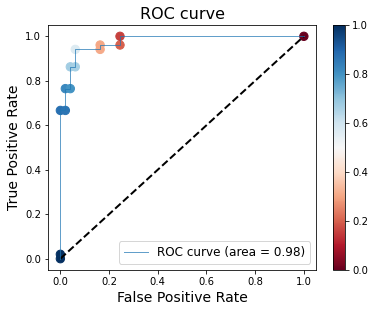

In [19]:
plt.figure(figsize=(6, 4.5))
plot_roc_curve(y_test, y_score)

In [20]:
def plot_pr_curve(y_test, y_score, title=None, label=None, legend=True, 
                   show_thresholds=True, colorbar=True):
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    precision = precision[:-1]
    recall = recall[:-1]
    avg_prec = average_precision_score(y_test, y_score)

    if label is None:
        label='PR curve (area = %0.2f)' % avg_prec

    if title is None:
        title = "PR curve"
    
    if show_thresholds:
        norm = plt.Normalize(vmin=0, vmax=1)
        plt.plot(recall, precision, lw=1, label=label, alpha=0.7)
        plt.scatter(recall, precision, cmap=cm, c=thresholds, s=70, norm=norm)
        if colorbar:
            plt.colorbar()
    else:
        plt.plot(recall, precision, lw=3, label=label)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title(title, fontsize=16)
    if legend:
        plt.legend(fontsize=12)

def plot_pr_curves(y_test, y_scores, labels, title=None, show_thresholds=True):
    for y_score, label in zip(y_scores, labels):
        plot_pr_curve(y_test, y_score, label=label, legend=False, 
                       show_thresholds=show_thresholds, colorbar=False)
    plt.legend(fontsize=12)
    if show_thresholds:
        plt.colorbar()
    if title is not None:
        plt.title(title, fontsize=16)   

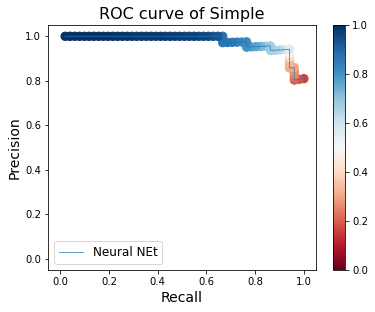

In [21]:
plt.figure(figsize=(6, 4.5))
plot_pr_curves(y_test, [y_score], 
               labels=["Neural NEt"],
               title="ROC curve of Simple")